## Project 4: ~~Stock~~ Crypto Predictor

### Prompt

*"Due to the volatility of cryptocurrency speculation, investors will often try to incorporate sentiment from social media and news articles to help guide their trading strategies. One such indicator is the Crypto Fear and Greed Index (FNG), which attempts to use a variety of data sources to produce a daily FNG value for cryptocurrency. You have been asked to help build and evaluate deep learning models using both the FNG values and simple closing prices to determine if the FNG indicator provides a better signal for cryptocurrencies than the normal closing price data."*

### Approach

At a high level, I'll follow these steps from the [Kaggle Time Series tutorials](https://www.kaggle.com/learn/time-series) to create a hybrid learning model that can forecast the BTC price: 
1. Explore the data to find the overall trend, plus any seasonal trends for the BTC close price.
2. Create features for these trends and fit them to a [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model.
3. Take the output of this model and subtract it from the original data.
4. With the residual data, identify any serial trends and create lag features for them.
5. Fit the lagged residuals to an [`XGBRegressor`](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor) model.
6. Combine the output of the first and second models to forecast the BTC close price.
7. Re-run the entire process with identical feature(s) for the crypto FNG values.
8. Measure each forecast against the actual close price and compare results.

Historical BTC/USD prices can be downloaded from [Yahoo Finance](https://finance.yahoo.com/quote/BTC-USD/history/), and the FNG index is available through [alternative.me](https://alternative.me/crypto/fear-and-greed-index/)'s public API:

In [1]:
import requests
import csv

response = requests.get('https://api.alternative.me/fng/?limit=0&format=CSV')
if response.status_code == requests.codes.ok:
    content = list(csv.reader(response.content.decode('utf-8').splitlines(), delimiter=','))
    with open('./data/crypto-FNG.csv', 'w', newline='') as file:
        writer = csv.writer(file, delimiter=',')
        writer.writerow(['date', 'fng_value', 'fng_classification']) # original headers arrive in the wrong order
        [writer.writerow(row) for row in content[4:]] # first 4 rows are titles, old headers, etc.
    print('Data retrieved.')
else:
    print('Fetch failed.')

Data retrieved.


In [2]:
import pandas

def load_time_series(path:str, index:str, target:str, **kwargs) -> pandas.DataFrame:
    data = pandas.read_csv(path, index_col=index, usecols=[index, target], **kwargs).dropna()
    data.index = pandas.to_datetime(data.index, **kwargs).to_period('D') # makes sorting work
    return data.sort_index()

btc_data = load_time_series('./data/BTC-USD.csv', 'Date', 'Close')
fng_data = load_time_series('./data/crypto-FNG.csv', 'date', 'fng_value', dayfirst=True)
data = btc_data.join(fng_data, how='inner').set_axis(['close', 'fng'], axis=1)

with pandas.option_context('display.max_rows', 4): display(data)

,close,fng
2018-02-01,9170.540039,30.0
2018-02-02,8830.750000,15.0
...,...,...
2023-07-30,29275.308594,52.0
2023-08-01,29315.177734,53.0


The FNG data won't get used for a while, but joining it now saves several steps down the road.

In [3]:
data.describe().transpose().round(2)

,count,mean,std,min,25%,50%,75%,max
close,2004.0,21082.97,16315.45,3236.76,8090.71,13759.05,30637.75,67566.83
fng,2004.0,43.19,21.69,5.00,25.00,40.00,58.00,95.00


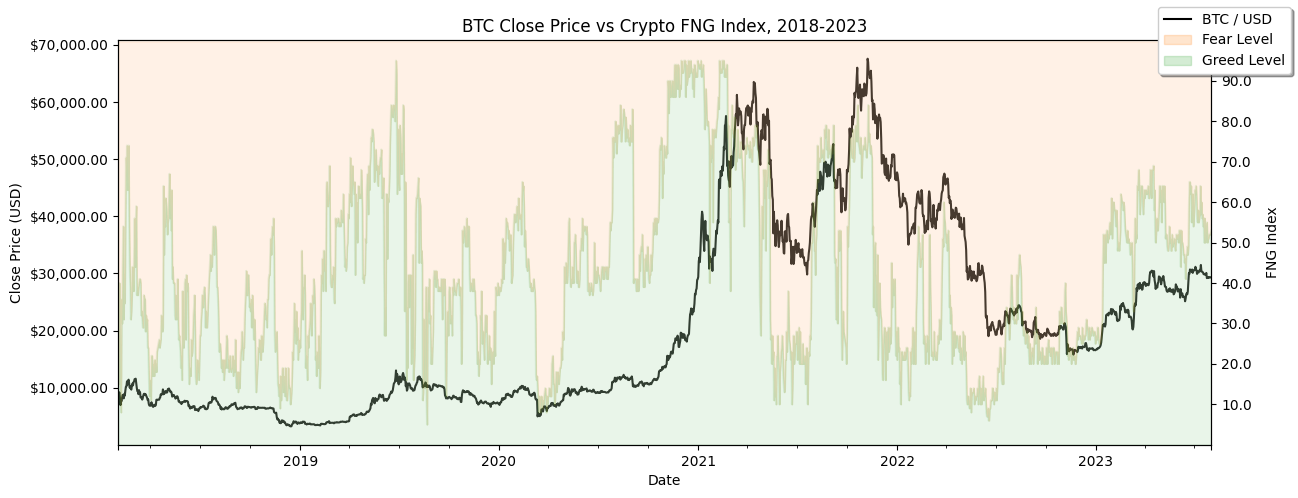

In [4]:
import matplotlib.pyplot as matplot
matplot.rc('figure', figsize=(13, 5), autolayout=True)
import numpy
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

fig, ax = matplot.subplots()
ax.set_title('BTC Close Price vs Crypto FNG Index, 2018-2023')
data.close.plot(ax=ax, alpha=0.8, xlabel='Date', ylabel='Close Price (USD)', label='BTC / USD', color='k')
ax.yaxis.set_major_formatter('${x:,.2f}')

ax2 = ax.twinx() # https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html
data.fng.plot(ax=ax2, alpha=0.1, kind='area', ylabel='FNG Index', label='Greed', color='C2')
ax2.fill_between(data.index, ax2.get_ylim()[1], data.fng, alpha=0.1, color='C1')
ticks = numpy.linspace(10, 100, num=10)
ax2.set_yticks(ticks, ticks)

legend = [ # https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html
    Line2D([], [], color='k', label='BTC / USD'),
    Patch(alpha=0.2, color='C1', label='Fear Level'),
    Patch(alpha=0.2, color='C2', label='Greed Level'),
]
fig.legend(handles=legend, shadow=True) # framealpha=1 also works
pass # suppress fig.legend() output

Looks like everything's in order. I'm a bit surprised by how well FNG follows the chart, and how quickly it changes from fear to greed and vice versa. Something to look into later but for now let's continue by searching for trends in the price data.

### Exploration, Round 1

Our goal is to find:
1. The underlying trend. This will ultimately be up, down, or flat.
2. Any seasonal trend(s). These add consistent fluctuations around the trendline.

Once we have #1 (and #2 if present), we can move on to the next step and start creating training features.

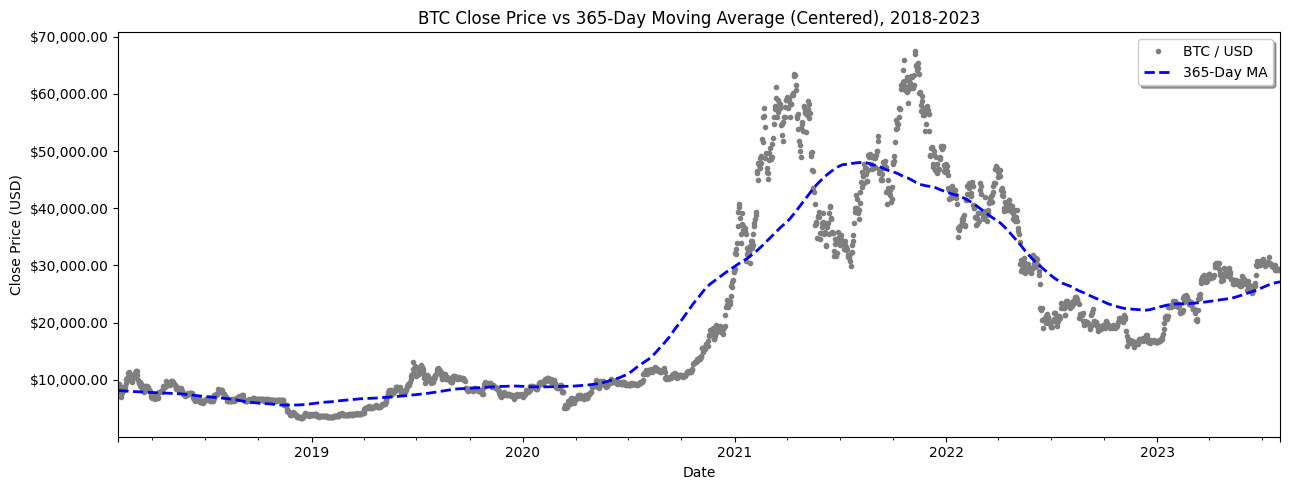

In [5]:
mavg = data.close.rolling(window=365, center=True, min_periods=180).mean()
ax = data.close.plot(style='.', color='C7', label='BTC / USD')
mavg.plot(ax=ax, style='--', color='b', label='365-Day MA', linewidth=2)
ax.set_title('BTC Close Price vs 365-Day Moving Average (Centered), 2018-2023')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price (USD)')
ax.yaxis.set_major_formatter('${x:,.2f}')
ax.legend(shadow=True)
pass

Seems upward to me. On to seasonal trends.

,close,fng,dayofweek,week,dayofyear,year
2018-02-01,9170.540039,30.0,3,5,32,2018
2018-02-02,8830.750000,15.0,4,5,33,2018
...,...,...,...,...,...,...
2023-07-30,29275.308594,52.0,6,30,211,2023
2023-08-01,29315.177734,53.0,1,31,213,2023


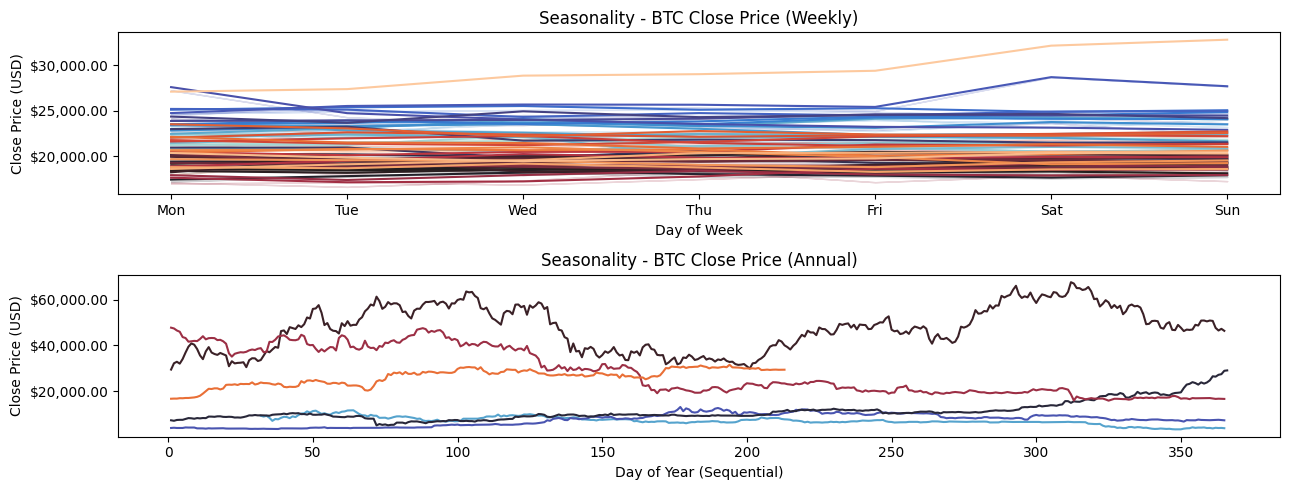

In [6]:
import seaborn

def make_seasonal(_data:pandas.DataFrame) -> pandas.DataFrame:
    seasonal_data = _data.copy()
    seasonal_data['dayofweek'] = seasonal_data.index.dayofweek
    seasonal_data['week'] = seasonal_data.index.week
    seasonal_data['dayofyear'] = seasonal_data.index.dayofyear
    seasonal_data['year'] = seasonal_data.index.year
    return seasonal_data

def plot_seasonal(_data:pandas.DataFrame, cycle:str, cycle_unit:str, target:str, ax:matplot.Axes=None, subtitle:str=None,
                  ytick_format:str=None, ylabel:str=None, xlabel:str=None, xticks:dict=None) -> matplot.Axes:
    if ax is None: _, ax = matplot.subplots()
    palette = seaborn.color_palette('icefire', n_colors=_data[cycle].nunique())
    ax = seaborn.lineplot(x=cycle_unit, y=target, hue=cycle, data=_data, ax=ax, legend=False, palette=palette, errorbar=('ci', False)) # not setting ci=False fills the area
    ax.set_title(f'Seasonality - {subtitle if subtitle else f"({cycle}/{cycle_unit})"}')
    if ytick_format: ax.yaxis.set_major_formatter(ytick_format)
    if ylabel: ax.set_ylabel(ylabel)
    if xlabel: ax.set_xlabel(xlabel)
    if xticks: ax.set_xticks([k for k in xticks.keys()], xticks.values())
    return ax

seasonal = make_seasonal(data)
fig, axs = matplot.subplots(2, 1)
subtitle = 'BTC Close Price'
weekdays = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
shared_args = dict(target='close', ytick_format='${x:,.2f}', ylabel='Close Price (USD)')
plot_seasonal(seasonal, cycle='week', cycle_unit='dayofweek', ax=axs[0], subtitle=f'{subtitle} (Weekly)', xlabel='Day of Week', xticks=weekdays, **shared_args)
plot_seasonal(seasonal, cycle='year', cycle_unit='dayofyear', ax=axs[1], subtitle=f'{subtitle} (Annual)', xlabel='Day of Year (Sequential)', **shared_args)
with pandas.option_context('display.max_rows', 4): display(seasonal)

I see a weekly cycle that peaks around Saturday, but can't make sense of the annual chart; the price jump around 2021 makes it hard to compare earlier years. Let's try looking at `pct_change()` instead.

*Side note — for some reason the y-scale on the weekly chart is halved. I tried explicitly scaling the y-axis to the `max()` and `min()` values of the data, but this also descaled the displayed data. At this point I can spend another half-hour debugging a ~~shart~~ chart label or just let it go... so for the sake of time I'm going to take the L and move on.*

,close,fng,dayofweek,week,dayofyear,year,close_pct
2018-02-01,9170.540039,30.0,3,5,32,2018,0.000000
2018-02-02,8830.750000,15.0,4,5,33,2018,-3.705235
...,...,...,...,...,...,...,...
2023-07-30,29275.308594,52.0,6,30,211,2023,-0.277990
2023-08-01,29315.177734,53.0,1,31,213,2023,0.136187


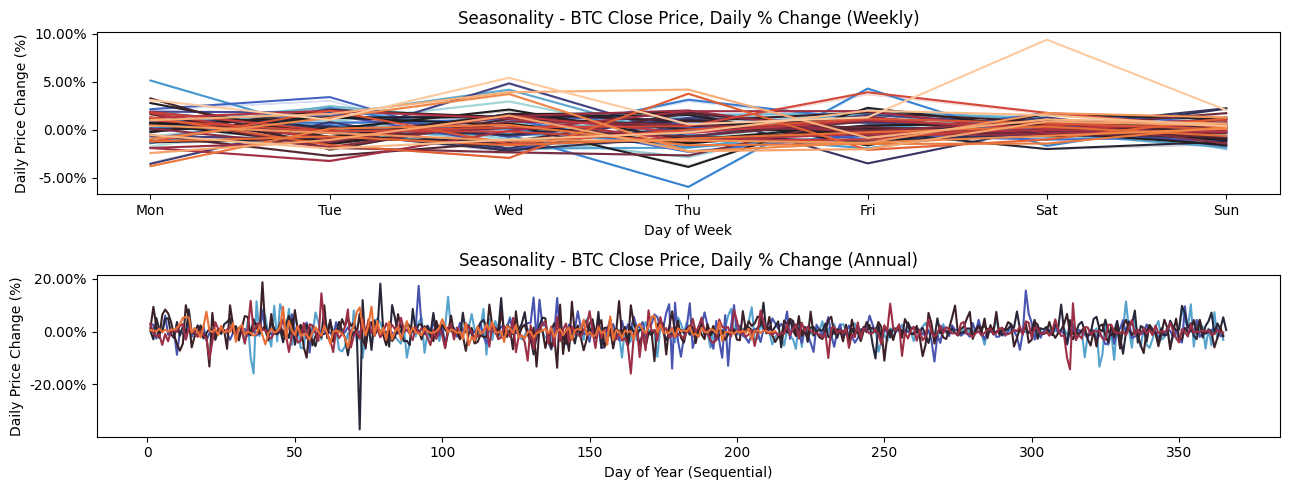

In [7]:
seasonal['close_pct'] = seasonal.close.pct_change().fillna(0.0) * 100 # upscaled for label formatting
fig, axs = matplot.subplots(2, 1)
subtitle = 'BTC Close Price, Daily % Change'
shared_args = dict(target='close_pct', ytick_format='{x:,.2f}%', ylabel='Daily Price Change (%)')
plot_seasonal(seasonal, cycle='week', cycle_unit='dayofweek', ax=axs[0], subtitle=f'{subtitle} (Weekly)', xlabel='Day of Week', xticks=weekdays, **shared_args)
plot_seasonal(seasonal, cycle='year', cycle_unit='dayofyear', ax=axs[1], subtitle=f'{subtitle} (Annual)', xlabel='Day of Year (Sequential)', **shared_args)
with pandas.option_context('display.max_rows', 4): display(seasonal)

This shows a much stonger mid-cycle trend on the weekly chart, which goes against my earlier observation. The annual plot on the other hand just looks like noise.

Thankfully, the tutorial covers how to use a [periodogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html#scipy.signal.periodogram), which is designed to find recurring frequencies in (sometimes literally) noisy data:

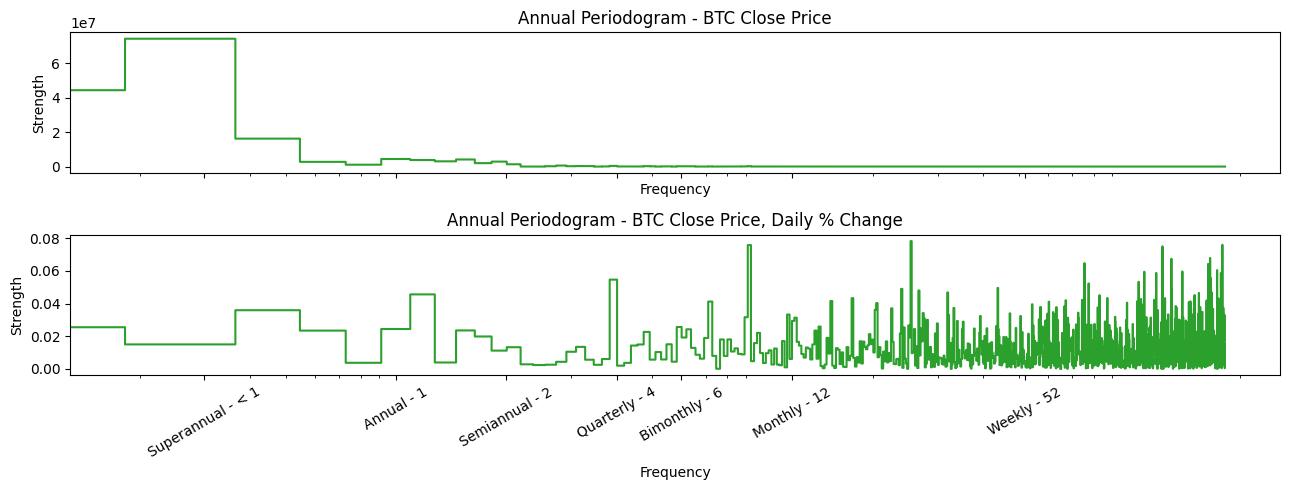

In [8]:
from scipy.signal import periodogram

def plot_periodogram(x:pandas.Series, ax:matplot.Axes=None, subtitle:str=None) -> matplot.Axes:
    freq, spec = periodogram(x=x, detrend='linear', window='boxcar', scaling='spectrum', fs=365) # sample = 1 day, period = 1 year, frequency sampling = days / year
    if not ax: _, ax = matplot.subplots()
    ax.step(freq, spec, color='C2')
    ax.set_title(f'Annual Periodogram{" - " + subtitle if subtitle else ""}')
    ax.set_ylabel('Strength')
    ax.set_xlabel('Frequency')
    ax.set_xscale('log')
    ax.set_xticks([0.3, 1, 2, 4, 6, 12, 52])
    ax.set_xticklabels(['Superannual - < 1', 'Annual - 1', 'Semiannual - 2', 'Quarterly - 4', 'Bimonthly - 6', 'Monthly - 12', 'Weekly - 52'], rotation=30)
    return ax

fig, axs = matplot.subplots(2, 1, sharex=True)
plot_periodogram(seasonal.close, ax=axs[0], subtitle='BTC Close Price')
plot_periodogram(seasonal.close_pct, ax=axs[1], subtitle='BTC Close Price, Daily % Change')
pass

Well, those are two *very* different charts. But they both have a fall off around *Semiannual* (2), indicating a seasonal trend roughly in that range. Arguments could be made for *Annual* (1) or *Superannual* (<1), but since this defines an integer with a floor of 1 anyway, I'll use 2 (*Semiannual*) to keep things interesting.

### Regression, Round 1

Here's the plan:
1. Split the data so we have separate segments to model and measure our features. I'll use 2018-2022 data for training and 2023 for testing.
2. Use a statistical model, [`DeterministicProcess`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.deterministic.DeterministicProcess.html), to create the training feature(s), `X`, for the overall trend by indexing `y_train` from 0 to `len(y_train)`. Using this approach allows us to also mix in a [`CalendarFourier`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.deterministic.CalendarFourier.html) component to capture the seasonal cycle(s) of `X`.
3. Feed `X` into a `LinearRegression` to fit a trendline on `y_train` and predict a forecast for `y_test`. 
4. Repeat this process with different parameters and use `mean_absolute_error` and `mean_squared_error` to measure and compare results.

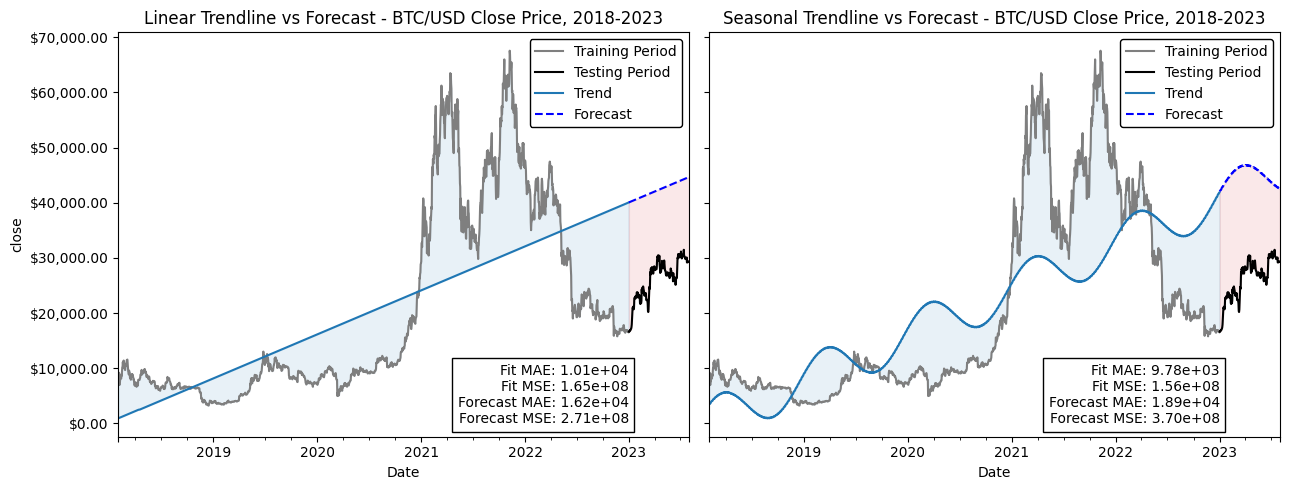

In [39]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

def plot_trendline(y:pandas.Series, cutoff:str='01-01-2023', order:int=1, seasonal:int=0, ax:matplot.Axes=None, subtitle:str=None, ylabel:str=None) -> (matplot.Axes, pandas.Series):
    y_train, y_test = y.loc[y.index < cutoff], y.loc[y.index >= cutoff]
    seasonal_args = dict(seasonal=seasonal, additional_terms=[CalendarFourier(freq='A', order=seasonal)]) if seasonal else {}
    dp = DeterministicProcess(index=y_train.index, order=order, constant=True, drop=True, **seasonal_args)
    X_train, X_test = dp.in_sample(), dp.out_of_sample(steps=len(y_test), forecast_index=y_test.index)
    model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
    y_trend = pandas.Series(model.predict(X_train), index=y_train.index)
    y_forecast = pandas.Series(model.predict(X_test), index=y_test.index)
    if ax is None: _, ax = matplot.subplots()
    ax.set_title(f'{"Seasonal" if seasonal else "Linear"} Trendline vs Forecast{" - " + subtitle if subtitle else ""}')
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel if ylabel else y.name)
    ax.yaxis.set_major_formatter('${x:,.2f}')
    ax = y_train.plot(ax=ax, color='C7', label='Training Period')
    ax = y_test.plot(ax=ax, color='k', label='Testing Period')
    ax = y_trend.plot(ax=ax, color='C0', label='Trend')
    ax = y_forecast.plot(ax=ax, color='b', style='--', label='Forecast')
    ax.fill_between(y_train.index, y_train, y_trend, color='C0', alpha=0.1)
    ax.fill_between(y_test.index, y_test, y_forecast, color='C3', alpha=0.1)
    legend_args = dict(facecolor='w', edgecolor='k')
    ax.legend(framealpha=1, **legend_args)
    errors = { 
        'Fit MAE': mean_absolute_error(y_train, y_trend),
        'Fit MSE': mean_squared_error(y_train, y_trend),
        'Forecast MAE': mean_absolute_error(y_test, y_forecast),
        'Forecast MSE': mean_squared_error(y_test, y_forecast),
    }
    ax.text(x=cutoff, y=min(y_forecast.min(), y.min(), 0), s='\n'.join([f'{e}: {errors[e]:.2e}' for e in errors]), ha='right', bbox=dict(alpha=1, **legend_args))
    return ax, pandas.concat([y_trend, y_forecast])

y = data.close.copy()
fig, axs = matplot.subplots(1, 2, sharey=True)
subtitle = 'BTC/USD Close Price, 2018-2023'
plot_trendline(y, ax=axs[0], subtitle=subtitle)
plot_trendline(y, ax=axs[1], subtitle=subtitle, seasonal=1)
pass

Interesting. The training fit would suggest that seasonal is the way to go, but the forecast error is actually lower for the standard linear trendline. What do higher trend orders look like? What does our trend look like with semiannual (`seasonal=2`) seasonality?

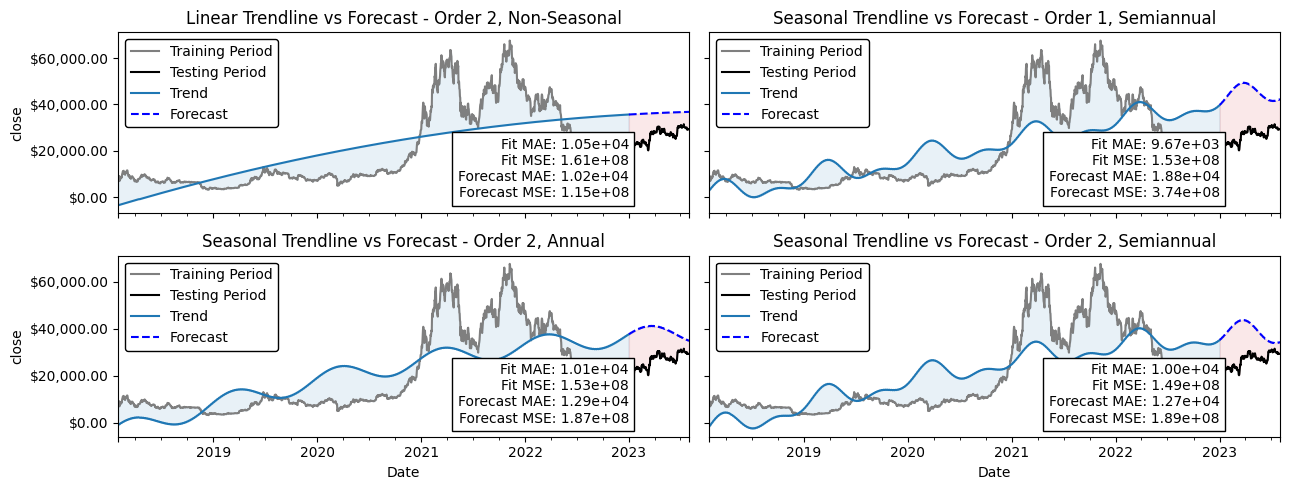

In [40]:
fig, axs = matplot.subplots(2, 2, sharex=True, sharey='row')
plot_trendline(y, ax=axs[0][0], order=2, subtitle='Order 2, Non-Seasonal')
plot_trendline(y, ax=axs[0][1], seasonal=2, subtitle='Order 1, Semiannual')
plot_trendline(y, ax=axs[1][0], order=2, seasonal=1, subtitle='Order 2, Annual')
plot_trendline(y, ax=axs[1][1], order=2, seasonal=2, subtitle='Order 2, Semiannual')
pass

*Order 1, Semiannual* looks like the winner, but it's the *Order 2, Non-Seasonal* curve that has the best forecast, even compared to the previous two. I'll try pushing the order and seasonality a bit just to see what we get.

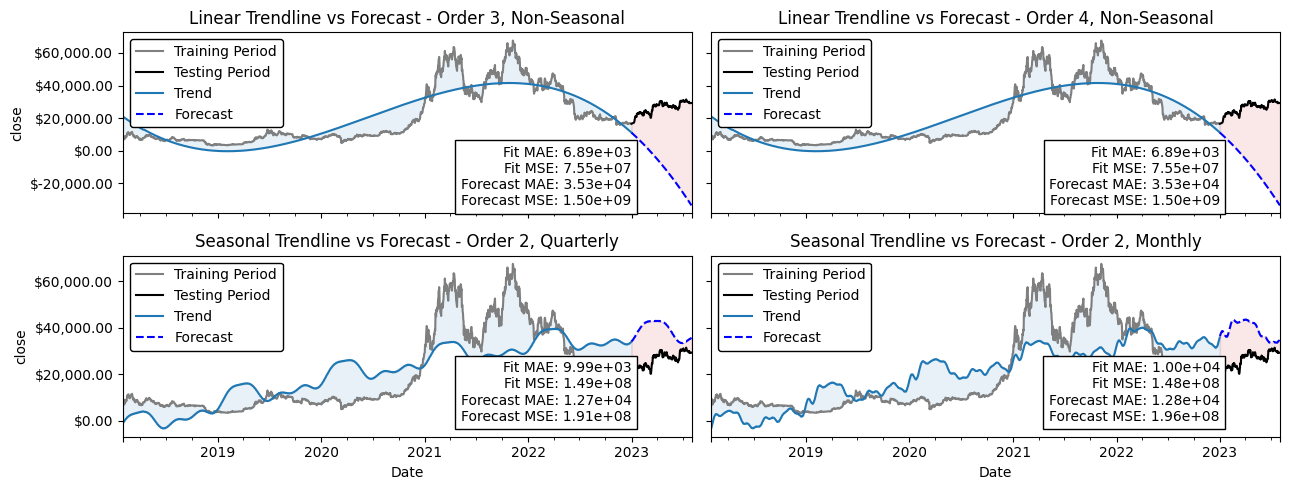

In [41]:
fig, axs = matplot.subplots(2, 2, sharex=True, sharey='row')
plot_trendline(y, ax=axs[0][0], order=3, subtitle='Order 3, Non-Seasonal')
plot_trendline(y, ax=axs[0][1], order=3, subtitle='Order 4, Non-Seasonal')
plot_trendline(y, ax=axs[1][0], order=2, seasonal=4, subtitle='Order 2, Quarterly')
plot_trendline(y, ax=axs[1][1], order=2, seasonal=12, subtitle='Order 2, Monthly')
pass

Interesting that none of these beat *Order 2, Non-Seasonal*. Also interesting that the seasonal features are making the fit worse. Let's look at the periodogram again for just the training data:

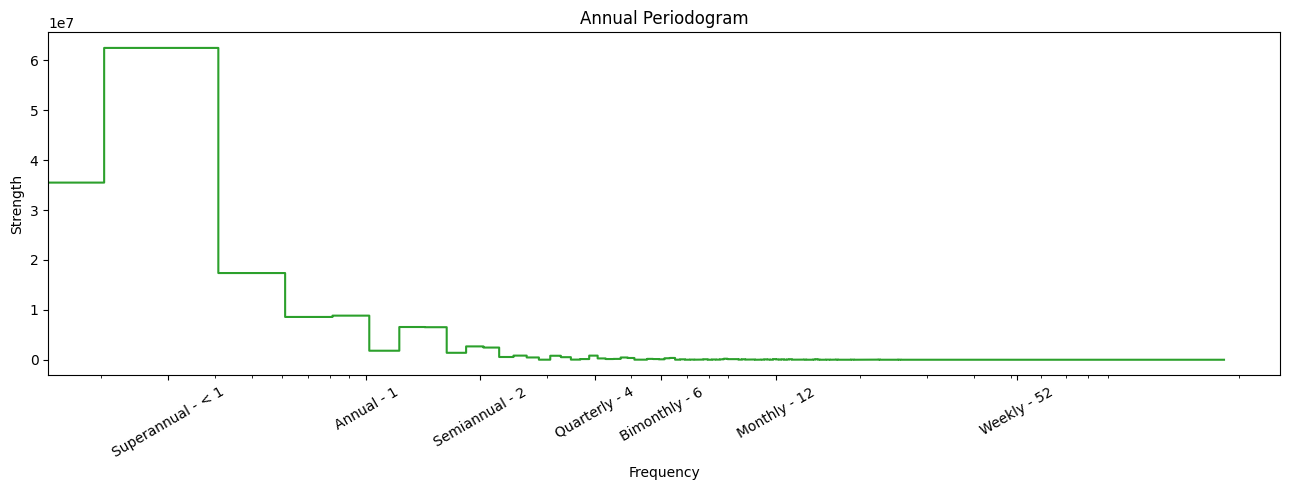

In [42]:
plot_periodogram(x=y.loc[y.index < '01-01-2023'])
pass

The case for *Superannual* (<1) seems much more pertinent now. I'll rewrite `plot_trend_forecast` to use a standard [`Fourier`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.deterministic.Fourier.html#statsmodels.tsa.deterministic.Fourier) instead of `CalendarFourier` so we can scale it to multiple years.

`Fourier` accepts an `order` just like `CalendarFourier`, but instead of scaling to a period automatically, we pass the number of samples that would be in a full cycle — i.e., 365 x the number of years.

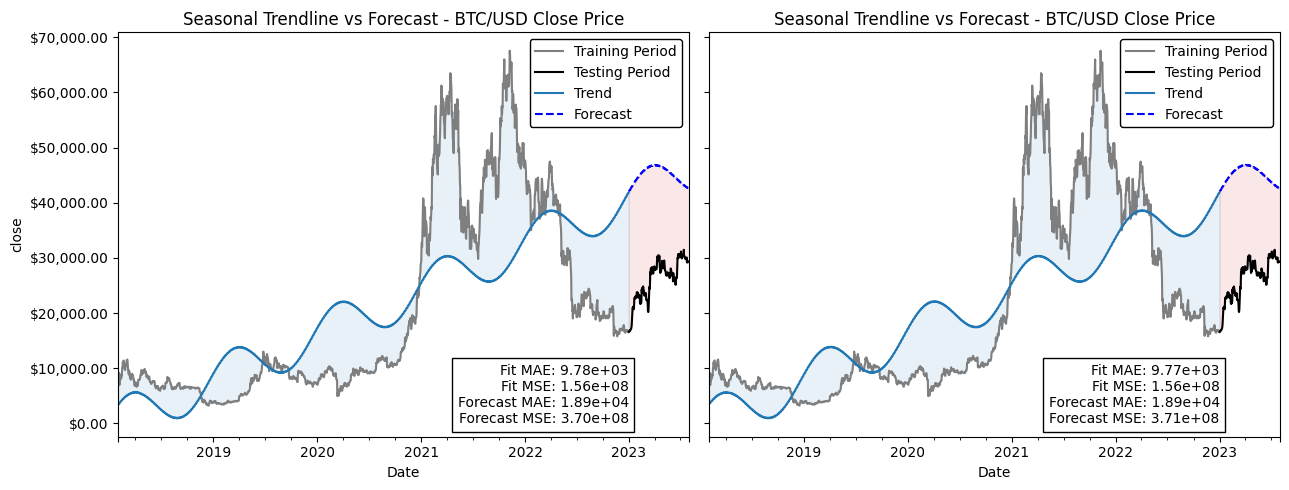

In [51]:
from statsmodels.tsa.deterministic import Fourier

def plot_trendline_v2(y:pandas.Series, cutoff:str='01-01-2023', order:int=1, years:int=1, seasonal:int=0, ax:matplot.Axes=None, subtitle:str=None, ylabel:str=None) -> tuple[matplot.Axes, pandas.Series]:
    y_train, y_test = y.loc[y.index < cutoff], y.loc[y.index >= cutoff]
    seasonal_args = dict(seasonal=seasonal, additional_terms=[Fourier(period=365*years, order=seasonal)]) if seasonal else {}
    dp = DeterministicProcess(index=y_train.index, order=order, constant=True, drop=True, **seasonal_args)
    X_train, X_test = dp.in_sample(), dp.out_of_sample(steps=len(y_test), forecast_index=y_test.index)
    model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
    y_trend = pandas.Series(model.predict(X_train), index=y_train.index)
    y_forecast = pandas.Series(model.predict(X_test), index=y_test.index)
    if ax is None: _, ax = matplot.subplots()
    ax.set_title(f'{"Seasonal" if seasonal else "Linear"} Trendline vs Forecast{" - " + subtitle if subtitle else ""}')
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel if ylabel else y.name)
    ax.yaxis.set_major_formatter('${x:,.2f}')
    ax = y_train.plot(ax=ax, color='C7', label='Training Period')
    ax = y_test.plot(ax=ax, color='k', label='Testing Period')
    ax = y_trend.plot(ax=ax, color='C0', label='Trend')
    ax = y_forecast.plot(ax=ax, color='b', style='--', label='Forecast')
    ax.fill_between(y_train.index, y_train, y_trend, color='C0', alpha=0.1)
    ax.fill_between(y_test.index, y_test, y_forecast, color='C3', alpha=0.1)
    legend_args = dict(facecolor='w', edgecolor='k')
    ax.legend(framealpha=1, **legend_args)
    errors = { 
        'Fit MAE': mean_absolute_error(y_train, y_trend),
        'Fit MSE': mean_squared_error(y_train, y_trend),
        'Forecast MAE': mean_absolute_error(y_test, y_forecast),
        'Forecast MSE': mean_squared_error(y_test, y_forecast),
    }
    ax.text(x=cutoff, y=min(y_forecast.min(), y.min(), 0), s='\n'.join([f'{e}: {errors[e]:.2e}' for e in errors]), ha='right', bbox=dict(alpha=1, **legend_args))
    return ax, pandas.concat([y_trend, y_forecast])

fig, axs = matplot.subplots(1, 2, sharey=True)
subtitle = 'BTC/USD Close Price'
plot_trendline(y, ax=axs[0], subtitle=subtitle, seasonal=1)
plot_trendline_v2(y, ax=axs[1], subtitle=subtitle, years=1, seasonal=1)
pass

Good, it more or less matches the `CalendarFourier` version. Now let's really test it out.

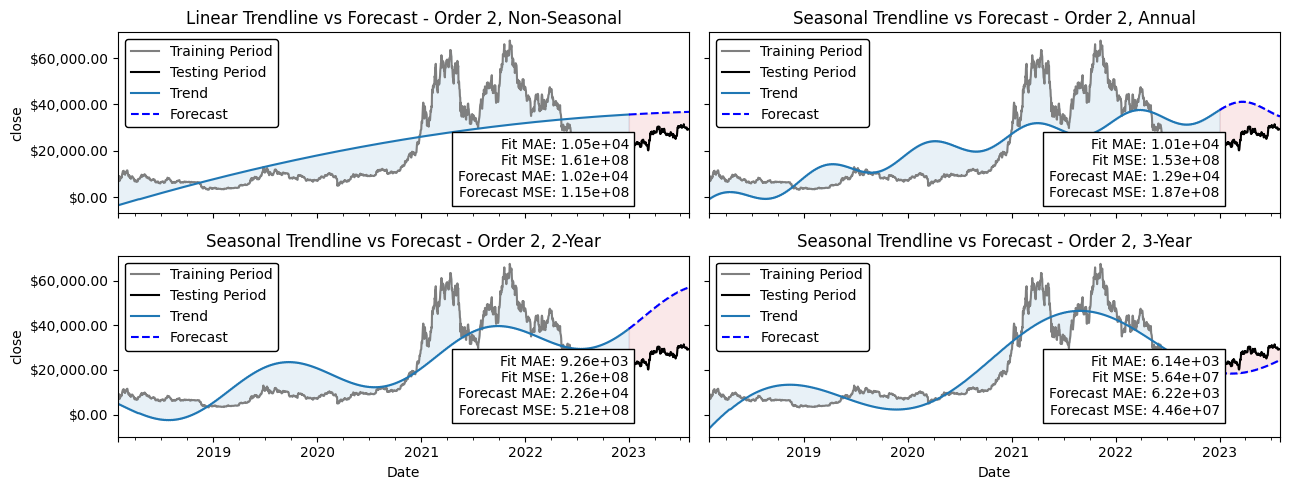

In [44]:
fig, axs = matplot.subplots(2, 2, sharex=True, sharey='row')
plot_trendline_v2(y, ax=axs[0][0], order=2, subtitle='Order 2, Non-Seasonal')
plot_trendline_v2(y, ax=axs[0][1], order=2, seasonal=1, subtitle='Order 2, Annual')
plot_trendline_v2(y, ax=axs[1][0], order=2, seasonal=1, years=2, subtitle='Order 2, 2-Year')
plot_trendline_v2(y, ax=axs[1][1], order=2, seasonal=1, years=3, subtitle='Order 2, 3-Year')
pass

I think we're onto something with the 3-year cycle! Is there a benefit to adding higher orders to the `Fourier`?

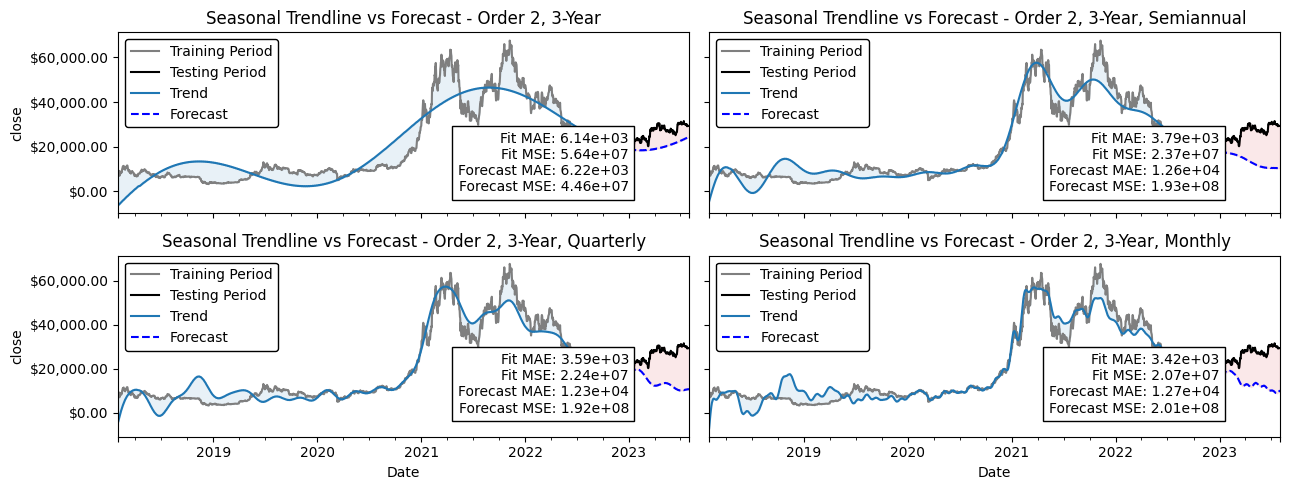

In [45]:
fig, axs = matplot.subplots(2, 2, sharex=True, sharey='row')
plot_trendline_v2(y, ax=axs[0][0], order=2, seasonal=1, years=3, subtitle='Order 2, 3-Year')
plot_trendline_v2(y, ax=axs[0][1], order=2, seasonal=6, years=3, subtitle='Order 2, 3-Year, Semiannual')
plot_trendline_v2(y, ax=axs[1][0], order=2, seasonal=12, years=3, subtitle='Order 2, 3-Year, Quarterly')
plot_trendline_v2(y, ax=axs[1][1], order=2, seasonal=36, years=3, subtitle='Order 2, 3-Year, Monthly')
pass

Fine, `seasonal=1` it is. 

Let's take another look at the final trendline before extracting it from our data.

2018-02-01    -6245.454886
2018-02-02    -6099.407933
                  ...     
2023-07-30    24339.206381
2023-08-01    24417.017191
Freq: D, Length: 2004, dtype: float64

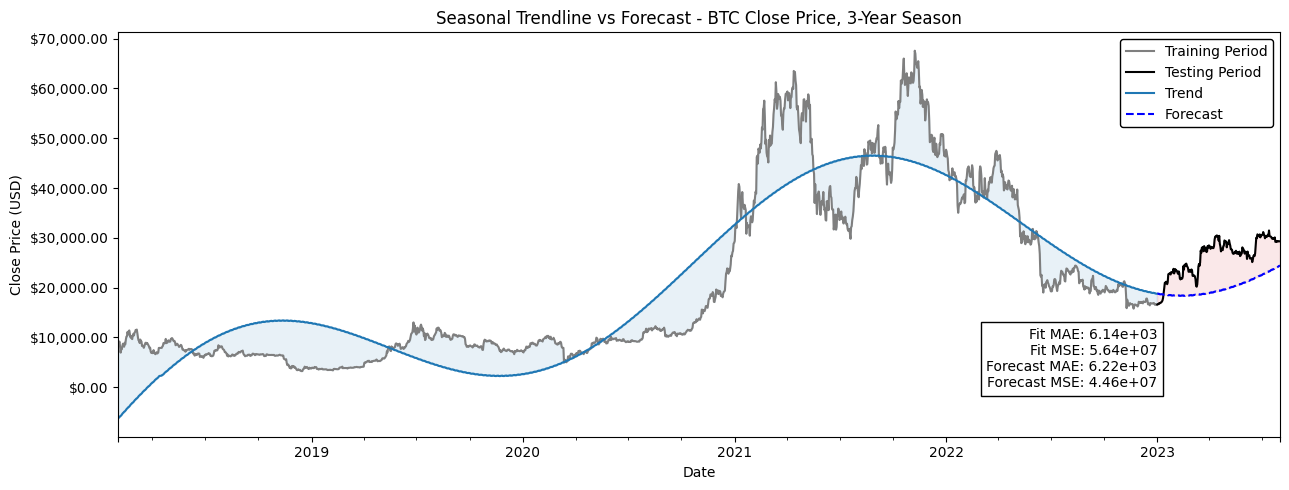

In [46]:
_, trendline = plot_trendline_v2(y, order=2, seasonal=1, years=3, subtitle='BTC Close Price, 3-Year Season', ylabel='Close Price (USD)')
with pandas.option_context('display.max_rows', 4): display(trendline)

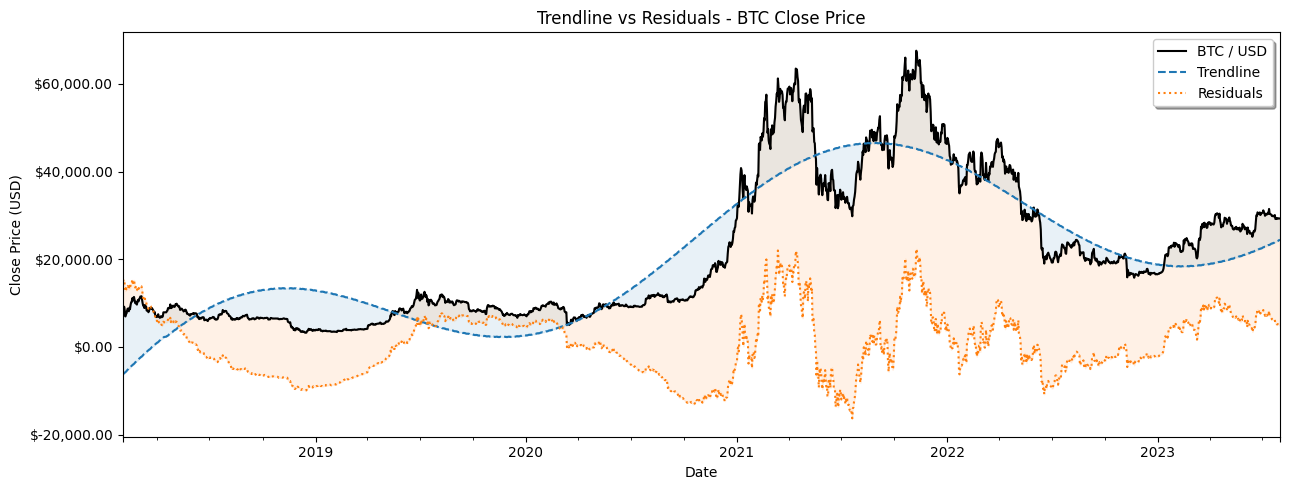

In [64]:
residuals = y - trendline
ax = y.plot(color='k', label='BTC / USD')
ax = trendline.plot(ax=ax, color='C0', label='Trendline', style='--')
ax = residuals.plot(ax=ax, color='C1', label='Residuals', style=':')
ax.fill_between(y.index, y, trendline, color='C0', alpha=0.1)
ax.fill_between(y.index, y, residuals, color='C1', alpha=0.1)
ax.set_title('Trendline vs Residuals - BTC Close Price')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price (USD)')
ax.yaxis.set_major_formatter('${x:,.2f}')
ax.legend(shadow=True)
pass

### Exploration, Round 2

In [66]:
def foo(): print('bar')